In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/toxic-comments-classification-2023/sample_submission.csv
/kaggle/input/toxic-comments-classification-2023/train_data.csv
/kaggle/input/toxic-comments-classification-2023/test_data.csv


In [2]:
!pip install pymorphy2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 68.3 MB/s eta 0:00:00:00:0100:01


In [3]:
import matplotlib.pyplot as plt
import torch
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from pymorphy2 import MorphAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from gensim.models import FastText
from gensim.models import Word2Vec
import fasttext
import torch.nn as nn
import gensim.downloader as api
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
df_train = pd.read_csv('/kaggle/input/toxic-comments-classification-2023/train_data.csv')
df_test = pd.read_csv('/kaggle/input/toxic-comments-classification-2023/test_data.csv')
ss = pd.read_csv('/kaggle/input/toxic-comments-classification-2023/sample_submission.csv')

In [40]:
df_train.head()

,comment,toxic
0,Преступление и наказание\n,0.0
1,"И именно эти неработающие весы показывают, что...",0.0
2,"В Японии такие панельки, ебанько.\n",0.0
3,Еще у нас выявляют трещины с помощью белой кра...,0.0
4,"Дочитал до поезда в Норильск , дальше не стал\n",0.0


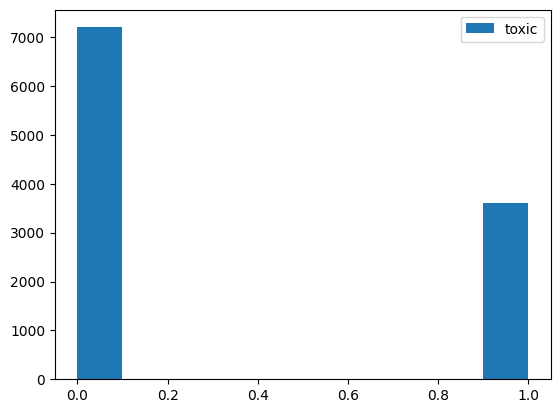

In [41]:
plt.hist(df_train['toxic'], label='toxic')
plt.legend()

In [42]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()

In [43]:
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    
    return tokens
    

In [44]:
df_train['preprocess_text'] = df_train['comment'].apply(lemmatize)
df_test['preprocess_text'] = df_test['comment'].apply(lemmatize)

# TF-IDF

In [ ]:
X_train = df_train['preprocess_text']
y_train = df_train['toxic']

X_test = df_test['preprocess_text']

In [14]:
X_train = X_train.apply(lambda x: ' '.join(x))
X_test = X_test.apply(lambda x: ' '.join(x))

In [36]:
tfidf_vectorizer = TfidfVectorizer()

In [37]:
X_train_tf_idf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tfidf_vectorizer.transform(X_test)

In [38]:
X_train_tf_idf.shape, X_test_tf_idf.shape

((10809, 27556), (3603, 27556))

In [40]:
model = LogisticRegression()
model.fit(X_train_tf_idf, y_train)

LogisticRegression()

# Kaggle score: 0.84484

# RNN


In [11]:
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [11]:
word2vec = api.load("glove-twitter-100")

[==================================================] 100.0% 387.1/387.1MB downloaded


In [45]:
word2idx = {word: idx for idx, word in enumerate(word2vec.index_to_key)}

In [46]:
def encode(word):
    if word in word2idx.keys():
        return word2idx[word]
    return word2idx["unk"]

(array([3.761e+03, 3.067e+03, 1.500e+03, 8.360e+02, 4.840e+02, 3.190e+02,
        2.230e+02, 1.320e+02, 1.170e+02, 7.300e+01, 5.300e+01, 2.300e+01,
        2.800e+01, 3.000e+01, 2.400e+01, 1.900e+01, 1.100e+01, 1.600e+01,
        1.100e+01, 4.000e+00, 7.000e+00, 6.000e+00, 2.000e+00, 5.000e+00,
        7.000e+00, 4.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        4.000e+00, 6.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

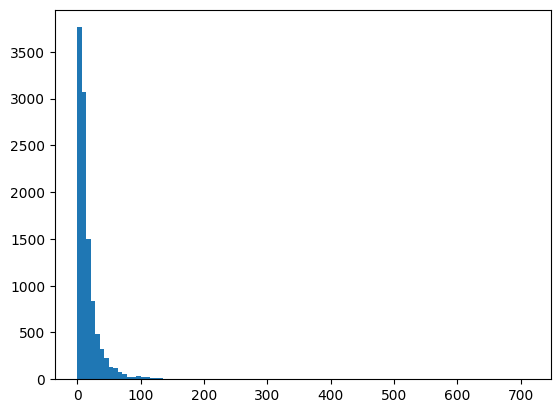

In [47]:
len_x = []
for x in df_train['preprocess_text']:
    len_x.append(len(x))
plt.hist(len_x, bins=100)

In [48]:
max_len = 50

In [49]:
df_train['embed_index'] = df_train['preprocess_text'].map(
    lambda x: [encode(word) for word in x[:max_len]]
)
df_test['embed_index'] = df_test['preprocess_text'].map(
    lambda x: [encode(word) for word in x[:max_len]]
)

In [50]:
df_train = df_train.drop(['comment', 'preprocess_text'], axis=1)
df_test = df_test.drop(['comment_id', 'comment', 'preprocess_text'], axis=1)

In [51]:
df_train['toxic'] = df_train['toxic'].map(
    lambda x: torch.tensor(x)
)
df_train['embed_index'] = df_train['embed_index'].apply(
    lambda x: torch.tensor(x)
)
df_test['embed_index'] = df_test['embed_index'].apply(
    lambda x: torch.tensor(x, dtype=torch.long)
)

In [52]:
df_train

,toxic,embed_index
0,tensor(0.),"[tensor(166043), tensor(138134)]"
1,tensor(0.),"[tensor(495), tensor(21860), tensor(62980), te..."
2,tensor(0.),"[tensor(360), tensor(163773), tensor(10107), t..."
3,tensor(0.),"[tensor(11618), tensor(62980), tensor(858203),..."
4,tensor(0.),"[tensor(556746), tensor(87052), tensor(493047)..."
...,...,...
10804,tensor(0.),"[tensor(1074), tensor(14895), tensor(40981), t..."
10805,tensor(1.),"[tensor(22869), tensor(76237), tensor(62980), ..."
10806,tensor(1.),"[tensor(360), tensor(856547), tensor(397382), ..."
10807,tensor(0.),"[tensor(50550), tensor(542447), tensor(7953), ..."


In [54]:
df_train = df_train.drop(df_train[df_train['embed_index'].apply(lambda x: len(x) == 0)].index)

In [55]:
df_train['embed_index'] = df_train['embed_index'].apply(lambda x: torch.nn.functional.pad(x, (0, max_len - len(x))))
df_test['embed_index'] = df_test['embed_index'].apply(lambda x: torch.nn.functional.pad(x, (0, max_len - len(x))))

In [56]:
class ToxicDataset(Dataset):
    def __init__(self, df, data):
        self.x = df
        self.data = data
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, index):
        if self.data == 'train':
            return {'text': self.x['embed_index'].iloc[index], 'label': self.x['toxic'].iloc[index]}
        else:
            return {'text': self.x['embed_index'].iloc[index]}

In [57]:
X_train, X_val = train_test_split(df_train, random_state=42, test_size=0.1)
X_test = df_test

In [58]:
X_train.shape, X_test.shape, X_val.shape

((9722, 2), (3603, 1), (1081, 2))

In [59]:
batch_size = 32

In [60]:
train_set = ToxicDataset(X_train, 'train')
val_set = ToxicDataset(X_val, 'train')
test_set = ToxicDataset(X_test, 'test')

In [61]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=X_test.shape[0])

In [88]:
class ToxicRnn(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, num_classes):
        super(ToxicRnn, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, bias=True, dropout=0.2, batch_first=True)
        
        self.cls = nn.Linear(hidden_size, num_classes)
        self.embedding_layer = nn.Embedding.from_pretrained(torch.tensor(word2vec.vectors), freeze=False)
        self.dropout = nn.Dropout(0.2)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.embedding_layer(x)

        output, hidden = self.lstm(x)
        output = self.batch_norm(output.permute(0, 2, 1)).permute(0, 2, 1)
        output = self.dropout(output)
        output = output[:, -1, :]
        output = self.cls(output)
        return output

In [63]:
def one_epoch(model, criterion, optimizer, train_loader, val_loader): 
    val_loss = []
    train_loss = []
    total=0
    correct=0
    model.train()
    for x in train_loader:
        text = x['text'].to(device)
        label = x['label'].to(device)
        optimizer.zero_grad()
        pred = model(text)
        loss = criterion(pred, label.long())
        _, predicted = torch.max(pred.data, 1) 
        total += label.size(0)  
        correct += (predicted == label).sum().item()
        train_loss.append(loss)
        loss.backward()
        optimizer.step()
    acc_train = 100 * correct / total
    total=0
    correct=0
    model.eval()
    with torch.no_grad():
        for x in val_loader:
            text = x['text'].to(device)
            label = x['label'].to(device)
            pred = model(text)
            loss = criterion(pred, label.long())
            _, predicted = torch.max(pred.data, 1) 
            total += label.size(0)  
            correct += (predicted == label).sum().item()
            val_loss.append(loss)
    acc_val = 100 * correct / total
    return acc_train, torch.mean(torch.tensor(train_loss)), acc_val, torch.mean(torch.tensor(val_loss))

In [64]:
def train(model, criterion, optimizer, train_loader,val_loader, epochs): 
    train_loss = []
    acc_train = []
    acc_val = []
    val_loss = []
    for epoch in range(epochs):
        print(f'epoch № {epoch + 1}')
        a_t, l_t, a_v, l_v = one_epoch(model, criterion, optimizer, train_loader, val_loader)
        print(f'accuracy_train={a_t}, train_loss={l_t}, accuracy_val={a_v}, val_loss={l_v}')
        train_loss.append(l_t)
        acc_train.append(a_t)
        acc_val.append(a_v)
        val_loss.append(l_v)
    return train_loss, acc_train, val_loss, acc_val

In [65]:
def test(model, test_loader):
    total = 0
    correct=0
    for x in test_loader:
        text = x['text'].to(device)
        label = x['label'].to(device)
        pred = model(text)
        _, predicted = torch.max(pred.data, 1) 
        total += label.size(0)
        correct += (predicted == label).sum().item()
    acc = 100 * correct / total
    return acc

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [91]:
model = ToxicRnn(embed_size=100, hidden_size=64, num_layers=1, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 3

In [92]:
train_loss, train_acc, val_loss, val_acc = train(model, criterion, optimizer, train_loader, val_loader, epochs)

epoch № 1
accuracy_train=65.9329356099568, train_loss=0.6422298550605774, accuracy_val=77.52081406105458, val_loss=0.49347418546676636
epoch № 2
accuracy_train=83.8510594527875, train_loss=0.3879784941673279, accuracy_val=86.21646623496763, val_loss=0.3344036340713501
epoch № 3
accuracy_train=92.61468833573339, train_loss=0.20652176439762115, accuracy_val=86.86401480111009, val_loss=0.37869808077812195


# Kaggle score = 0.88481